In [1]:
# Cell 1: Imports and Setup
import os
import sys
import time
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import copy
from dataclasses import asdict

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import your specific modules
from models import Transformer, TransformerConfig
from data import text_dataset

# Configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_path = 'non_binary.pt' # Path to your pretrained full-precision model
batch_size = 12
accumulation_steps = 40
max_len = 1024
finetune_iters = 200  # How many steps to retrain after pruning
learning_rate = 1e-5  # Lower LR for fine-tuning

print(f"Running on {device}")


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Running on cuda


In [5]:
def get_model_and_data(ckpt_path):
    # 1. Load Checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
    config = TransformerConfig(
        n_layer     = 12,
        n_head      = 12,
        n_embd      = 768,
        dropout     = 0.0,
        vocab_size  = 50304,
        bias        = False,
        max_len     = max_len,
        
        mlp_proj    = nn.Linear,  
        qkv_proj    = nn.Linear,
        c_proj      = nn.Linear,
    )
    
    model = Transformer(config)
    
    # 3. Sanitize State Dict Keys
    state_dict = checkpoint['model']
    unwanted_prefixes = ['module.', '_orig_mod.']
    
    new_state_dict = {}
    for k, v in state_dict.items():
        new_k = k
        for prefix in unwanted_prefixes:
            if new_k.startswith(prefix):
                new_k = new_k.replace(prefix, '')
        new_state_dict[new_k] = v
        
    # 4. Load weights
    model.load_state_dict(new_state_dict)
    model.to(device)
    model = torch.compile(model)
    
    # 5. Load Data
    train_loader, val_loader = text_dataset.get_loader(
        batch_size=batch_size, 
        max_len=max_len, 
        num_workers=4,
        prefetch_factor=2
    )
    
    return model, train_loader, val_loader

def estimate_loss(model, dataloader, eval_iters=50):
    """Calculates validation loss."""
    model.eval()
    losses = []
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i >= eval_iters: break
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            losses.append(loss.item())
            
    model.train()
    return sum(losses) / len(losses)


In [8]:
# Cell 3: Pruning and Retraining Functions

def apply_pruning(model, amount):
    """
    Applies unstructured L1 pruning to all Linear layers inside model blocks.
    amount: float between 0.0 and 1.0 (percentage of connections to zero out)
    """
    print(f"Pruning {amount*100}% of parameters in Transformer Blocks...")
    
    # Iterate specifically over the transformer blocks
    for block in model.blocks:
        for name, module in block.named_modules():
            if isinstance(module, nn.Linear):
                prune.l1_unstructured(module, name='weight', amount=amount)
    return model

def finetune_model(model, train_loader, val_loader, steps=200, accum_steps=1):
    """
    Retraining loop with Gradient Accumulation, BF16, and Validation tracking.
    """
    print(f"Retraining for {steps} updates (Effective Batch Size: {batch_size * accum_steps})...")
    
    # Check for BF16 support
    use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    ptdtype = torch.bfloat16 if use_bf16 else torch.float32

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    
    # --- 1. Initial Evaluation (Step 0) ---
    # We check the loss *before* any training to see the impact of pruning
    initial_val_loss = estimate_loss(model, val_loader)
    print(f"   [Start] Step 0/{steps} | Val Loss: {initial_val_loss:.4f}")

    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    current_step = 0
    micro_step = 0
    data_iter = iter(train_loader)
    
    while current_step < steps:
        # --- Data Fetching ---
        try:
            x, y = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader)
            x, y = next(data_iter)
            
        x, y = x.to(device), y.to(device)
        
        # --- Forward Pass (with Autocast) ---
        with torch.amp.autocast(device_type='cuda', dtype=ptdtype, enabled=use_bf16):
            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss = loss / accum_steps 
        
        # --- Backward Pass ---
        loss.backward()
        micro_step += 1
        
        # --- Optimizer Step ---
        if micro_step % accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            current_step += 1
            
            # --- Periodic Logging & Validation ---
            if current_step % 20 == 0:
                # Calculate Validation Loss
                # Note: estimate_loss switches to eval(), so we must switch back to train() after
                val_loss = estimate_loss(model, val_loader)
                model.train() 
                
                train_loss_val = loss.item() * accum_steps
                print(f"   Step {current_step}/{steps} | Train Loss: {train_loss_val:.4f} | Val Loss: {val_loss:.4f}")
        
    return model

In [10]:
# Cell 4: Execution Loop

# Define pruning percentages to test
# 0.0 = Baseline, 0.9 = 90% sparse
pruning_ratios = [0.0, 0.25, 0.5, 0.75, 1]
results = {}

# Load baseline once to get initial state
base_model, train_loader, val_loader = get_model_and_data(checkpoint_path)

# 1. Get Baseline Loss
print("--- Evaluating Baseline ---")
base_loss = estimate_loss(base_model, val_loader)
results[0.0] = base_loss
print(f"Baseline Loss: {base_loss:.4f}\n")

# 2. Run Pruning Experiments
for ratio in pruning_ratios:
    if ratio == 0.0: continue
    
    print(f"--- Experiment: {ratio*100}% Pruning ---")
    
    # Reload fresh model for every experiment to avoid cumulative pruning
    # (Or use deepcopy if memory allows)
    model_copy = copy.deepcopy(base_model) 
    
    # 1. Prune
    apply_pruning(model_copy, amount=ratio)
    
    # 2. Retrain (Fine-tune)
    # Note: PyTorch pruning creates a mask. The optimizer updates the original weights,
    # and the mask is applied on forward pass. This allows the model to learn around the zeros.
    finetune_model(
        model_copy, 
        train_loader, 
        val_loader,  # <--- Add this
        steps=finetune_iters, 
        accum_steps=accumulation_steps
    )
    
    # 3. Evaluate
    val_loss = estimate_loss(model_copy, val_loader)
    results[ratio] = val_loss
    
    print(f"Result: {ratio*100}% Pruned -> Val Loss: {val_loss:.4f}\n")
    
    # Optional: Remove pruning hooks to make it permanent if saving
    # for block in model_copy.transformer.h:
    #     for m in block.modules():
    #         if isinstance(m, nn.Linear):
    #             prune.remove(m, 'weight')
    
    del model_copy
    torch.cuda.empty_cache()

print("Experiment Complete.")


--- Evaluating Baseline ---


Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors


Baseline Loss: 3.3130

--- Experiment: 25.0% Pruning ---
Pruning 25.0% of parameters in Transformer Blocks...
Retraining for 200 updates (Effective Batch Size: 480)...


Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors


   [Start] Step 0/200 | Val Loss: 3.3734


Token indices sequence length is longer than the specified maximum sequence length for this model (4290 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2557 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1446 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2521 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence leng

   Step 20/200 | Train Loss: 3.1608 | Val Loss: 3.3393


Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors


   Step 40/200 | Train Loss: 3.5626 | Val Loss: 3.3329


Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors


   Step 60/200 | Train Loss: 3.0421 | Val Loss: 3.3295


Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors


   Step 80/200 | Train Loss: 3.2966 | Val Loss: 3.3271


Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors


   Step 100/200 | Train Loss: 3.2664 | Val Loss: 3.3252


Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors


   Step 120/200 | Train Loss: 3.4897 | Val Loss: 3.3238


Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors


   Step 140/200 | Train Loss: 3.2651 | Val Loss: 3.3226


Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors


   Step 160/200 | Train Loss: 3.4663 | Val Loss: 3.3215


Token indices sequence length is longer than the specified maximum sequence length for this model (1304 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1452 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2567 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1192 > 1024). Running this sequence through the model will result in indexing errors


   Step 180/200 | Train Loss: 3.3781 | Val Loss: 3.3206


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 200/200 | Train Loss: 3.4427 | Val Loss: 3.3198


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

Result: 25.0% Pruned -> Val Loss: 3.3198

--- Experiment: 50.0% Pruning ---
Pruning 50.0% of parameters in Transformer Blocks...
Retraining for 200 updates (Effective Batch Size: 480)...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   [Start] Step 0/200 | Val Loss: 4.9478


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 20/200 | Train Loss: 3.5858 | Val Loss: 3.7611


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 40/200 | Train Loss: 3.8293 | Val Loss: 3.6224


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 60/200 | Train Loss: 3.2967 | Val Loss: 3.5794


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.i

   Step 80/200 | Train Loss: 3.5293 | Val Loss: 3.5560


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 100/200 | Train Loss: 3.4658 | Val Loss: 3.5398


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 120/200 | Train Loss: 3.6948 | Val Loss: 3.5274


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 140/200 | Train Loss: 3.4553 | Val Loss: 3.5174


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 160/200 | Train Loss: 3.6431 | Val Loss: 3.5089


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 180/200 | Train Loss: 3.5589 | Val Loss: 3.5017


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 200/200 | Train Loss: 3.6068 | Val Loss: 3.4954


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

Result: 50.0% Pruned -> Val Loss: 3.4954

--- Experiment: 75.0% Pruning ---
Pruning 75.0% of parameters in Transformer Blocks...
Retraining for 200 updates (Effective Batch Size: 480)...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   [Start] Step 0/200 | Val Loss: 13.6992


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 20/200 | Train Loss: 7.7042 | Val Loss: 7.5794


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 40/200 | Train Loss: 6.8096 | Val Loss: 6.8280


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 60/200 | Train Loss: 6.3911 | Val Loss: 6.3298


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 80/200 | Train Loss: 5.9940 | Val Loss: 5.9963


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 100/200 | Train Loss: 5.6154 | Val Loss: 5.7519


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 120/200 | Train Loss: 5.6371 | Val Loss: 5.5436


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 140/200 | Train Loss: 5.3842 | Val Loss: 5.3498


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 160/200 | Train Loss: 5.2663 | Val Loss: 5.1779


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 180/200 | Train Loss: 5.1368 | Val Loss: 5.0352


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 200/200 | Train Loss: 4.9303 | Val Loss: 4.9215


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

Result: 75.0% Pruned -> Val Loss: 4.9215

--- Experiment: 100% Pruning ---
Pruning 100% of parameters in Transformer Blocks...
Retraining for 200 updates (Effective Batch Size: 480)...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   [Start] Step 0/200 | Val Loss: 3.3130


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 20/200 | Train Loss: 3.1287 | Val Loss: 3.3082


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 40/200 | Train Loss: 3.5369 | Val Loss: 3.3066


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 60/200 | Train Loss: 3.0198 | Val Loss: 3.3055


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 80/200 | Train Loss: 3.2745 | Val Loss: 3.3047


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 100/200 | Train Loss: 3.2450 | Val Loss: 3.3040


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
:     can only test a child process
self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 120/200 | Train Loss: 3.4672 | Val Loss: 3.3036


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 140/200 | Train Loss: 3.2478 | Val Loss: 3.3031


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 160/200 | Train Loss: 3.4500 | Val Loss: 3.3027


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 180/200 | Train Loss: 3.3554 | Val Loss: 3.3023


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

   Step 200/200 | Train Loss: 3.4232 | Val Loss: 3.3020


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b9ab1cd30>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/op

Result: 100% Pruned -> Val Loss: 3.3020

Experiment Complete.


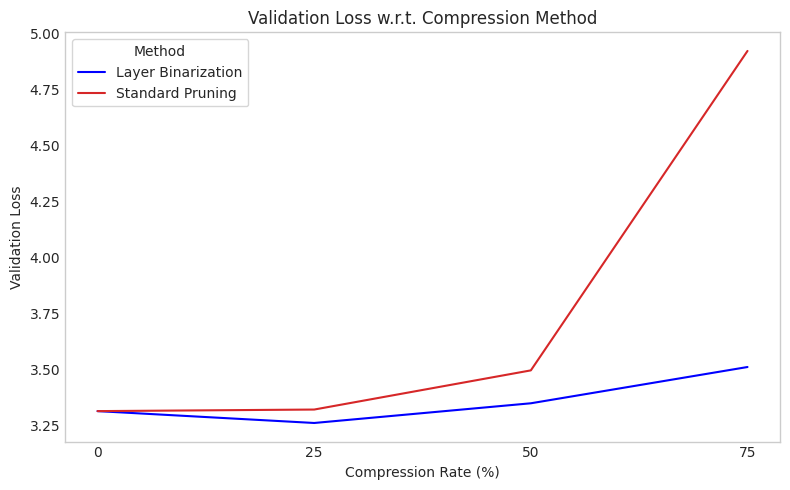

In [14]:
import matplotlib.pyplot as plt

# Data
compression_rates = [0, 25, 50, 75]
# "Normal" (Standard Pruning) -> Assigned RED
loss_normal = [3.313, 3.320, 3.495, 4.922]      
# "Binary" (Layer Binarization) -> Assigned BLUE
loss_binary = [3.313, 3.260, 3.348, 3.510] 

# Create figure with the specific aspect ratio from your image
plt.figure(figsize=(8, 5))

# Plotting with swapped colors
plt.plot(compression_rates, loss_binary, color='blue', label='Layer Binarization', linewidth=1.5)
plt.plot(compression_rates, loss_normal, color='#d62728', label='Standard Pruning', linewidth=1.5)

# Styling to match the reference image
plt.xlabel('Compression Rate (%)')
plt.ylabel('Validation Loss')
plt.title('Validation Loss w.r.t. Compression Method')

# Explicit X-ticks
plt.xticks([0, 25, 50, 75])

# Legend styling (Title inside, clean box)
plt.legend(title='Method', loc='upper left', frameon=True, edgecolor='#ccc')

# Remove grid (Clean white background)
plt.grid(False)

# Save the plot
plt.tight_layout()
plt.savefig('validation_loss_comparison.png', dpi=300)
plt.show()